 # <font color = #254117>[EEP 147]: ESG Analysis Round 0</font>

<div style="width:image width px; font-size:80%; text-align:center;"><img src="big_creek.jpg" alt="alternate text" width="500" height="height" style="padding-bottom:0.5em;" />Big Creek Hydroelectric Project - Southern California Edison</div>

This notebook can be utilized for analysis of the Electricity Strategy Game.

First on our agenda is to import **<font color = ##008700>dependencies</font>** -- packages in Python that add to the basic functions in Python -- same as before.

In [1]:
from datascience import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, Dropdown, IntSlider
import ipywidgets as widgets
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [10,6]

Next, let's select your portfolio. In the cell below, assign **section** to the section number that corresponds to your own according to the following table.

| Number | Section Time  |
|---------|---------------|
| 1 | Wednesday 8am |
| 2 | Wednesday 9am |
| 3 | Friday 2pm |
| 4 | Friday 3pm |

Assign **YOUR_PORTFOLIO** to the name of your portfolio from the following choices:

**'Bay Views',
 'Beachfront',
 'Big Coal',
 'Big Gas',
 'East Bay',
 'Fossil Light',
 'Old Timers'**
 
The variable **periods_completed** should be set to the most recently concluded round.

The variable **period** should be set to the round that you want to analyze.

The variable **hour** should be set to the hour that you want to analyze.

The variable **carbon_price_456** should contain carbon prices in each of rounds *[4, 5, 6]*.

The variable **pab_periods** should contain each of the periods for which there was or will be a pay-as-bid auction.  This shouldn't change.

The variable **bid_own_as_mc** should be set to *True* if you would like to default future bids for your own portfolio to marginal cost (inclusive of carbon price for rounds 4, 5, and 6).  If setting to *False*, you would need to go into the respective bids_.CSV file and manually edit other teams' future bids.  Note that even if *True*, the current round and hour's bids can be adjusted manually down below (after the bids_ variables are defined).

The variable **bid_others_as_mc** should be set to *True* if you would like to default future bids for other teams' portfolios to marginal cost (inclusive of carbon price for rounds 4, 5, and 6).  If setting to *False*, you would need to go into the respective bids_.CSV file and manually edit other teams' future bids.

In [2]:
section = 1
YOUR_PORTFOLIO = "Big Coal"
periods_completed = 0
period = 0
pab_periods = [1]

Next we import the demand forecasts.

In [3]:
demand_table = Table.read_table('demand.csv')

Next we import our Bids and Porfolios tables, with all bids set to MC.

In [4]:
bids_mc = Table.read_table('MC_bids.csv').sort('PORTFOLIO')
ESG = Table.read_table('ESGPorfolios.csv')

In the following cell we will join the tables based on the column **Plant_ID**.

In [5]:
joined_table_all = bids_mc.join("PLANT_ID", ESG, "Plant_ID").sort("PLANT_ID")

Now, let's create a function to determine the price given the bids and demand.

In [6]:
def price_calc(input_table, demand, hour, period):
    #hour and period determine which bids are taken from joined_table
    joined_table = input_table.copy()
    sorted_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    price = 0
    sum_cap = 0
    for i in range(0,len(sorted_table['Capacity_MW'])):
        if sum_cap + sorted_table['Capacity_MW'][i] > demand:
            price = sorted_table['PRICE' + str(hour)][i]
            break
        else:
            sum_cap += sorted_table['Capacity_MW'][i]
            price = sorted_table['PRICE' + str(hour)][i]
    return price

Now, let's create a function to plot the market in a given hour and period.

In [7]:
def find_x_pos(widths):
    cumulative_widths = [0]
    cumulative_widths.extend(np.cumsum(widths))
    half_widths = [i/2 for i in widths]
    x_pos = []
    for i in range(0, len(half_widths)):
        x_pos.append(half_widths[i] + cumulative_widths[i])
    return x_pos

def price_line_plot(price):
    plt.axhline(y=price, color='r', linewidth = 2)
    print("Price: " + str(price))
    
def demand_plot(demand):
    plt.axvline(x=demand, color='r', linewidth = 2)
    print("Capacity: " + str(demand))

def market_plot(input_table, demand, hour, period):
    joined_table = input_table.copy()
    sorted_joined_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    width = sorted_joined_table.column("Capacity_MW")
    height = sorted_joined_table.column('PRICE' + str(hour))
    x_vals = find_x_pos(width)
    energy_colors_dict = {}
    count = 0
    colors = ['#EC5F67', '#F29056', '#F9C863', '#99C794', '#5FB3B3', '#6699CC', '#C594C5']
    for i in set(sorted_joined_table['Group']):
        energy_colors_dict[i] = colors[count]
        count += 1
    colors_mapped = list(pd.Series(sorted_joined_table['Group']).map(energy_colors_dict))
    sorted_joined_table = sorted_joined_table.with_column('Color', colors_mapped)
    group_colors = sorted_joined_table.group("Group", lambda x: x).select("Group", "Color")
    group_colors["Color"] = group_colors.apply(lambda x: x[0], "Color")
    price = price_calc(sorted_joined_table, demand, hour, period)
    # Make the plot
    plt.figure(figsize=(9,6))
    plt.bar(x_vals, height, width=width, color=sorted_joined_table['Color'], edgecolor = "black")
    patches = []
    for row in group_colors.rows:
        patches += [mpatches.Patch(color=row.item("Color"), label=row.item("Group"))]
    plt.legend(handles=patches, bbox_to_anchor=(1.1,1))
    plt.title('All Energy Sources')
    plt.xlabel('Capacity_MW')
    plt.ylabel('Price')
    price_line_plot(price)
    demand_plot(demand)

The next cell plots the market.

Price: 38.06
Capacity: 10000


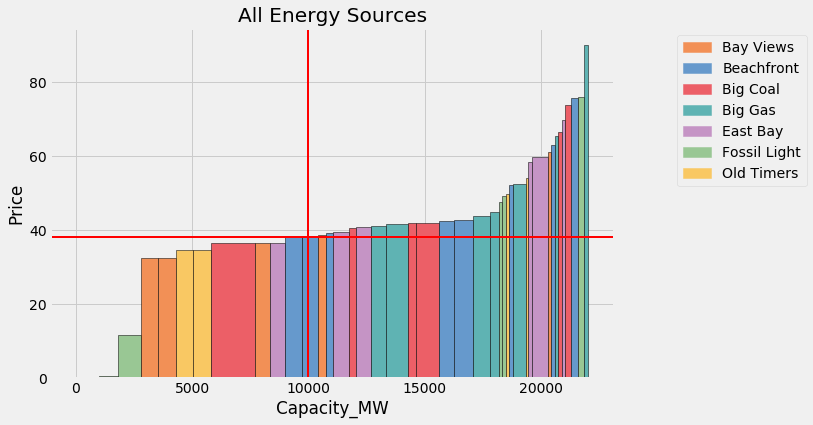

In [8]:
market_plot(input_table = joined_table_all, 
            demand = 10000, 
            hour = 1, 
            period = period)

Now, suppose that we implement a carbon price.  The next cell contains a function which will update our bids given a carbon price.

In [9]:
def market_plot_cp(input_table, demand, hour, period, carbon_price):
    joined_table = input_table.copy()
    joined_table["Total_Var_Cost_USDperMWH"] += carbon_price * joined_table["Carbon_tonsperMWH"]
    joined_table["PRICE" + str(hour)] += carbon_price * joined_table["Carbon_tonsperMWH"]
    market_plot(joined_table, demand, hour, period)

Let's re-plot the market, now with a carbon price.

Price: 48.6
Capacity: 10000


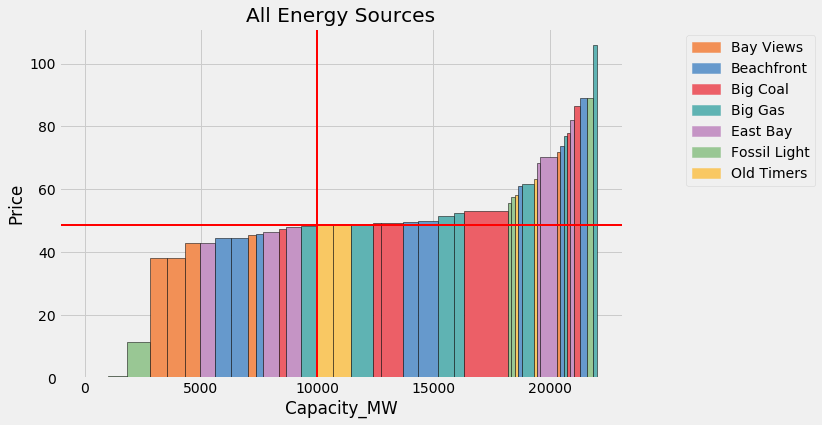

In [10]:
market_plot_cp(input_table = joined_table_all, 
               demand = 10000, 
               hour = 1, 
               period = period, 
               carbon_price = 15)

Let's zoom in on individual portolios to see which of their plants are operating.  A plant which bids a price below the market-clearing price will operate.  First, let's define a plotting function.

In [11]:
def portfolio_plot(input_table, demand, hour, period, portfolio):
    joined_table = input_table.copy()
    sorted_joined_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    your_source = sorted_joined_table.where("Group", portfolio)
    width_yours = your_source.column("Capacity_MW")
    height_yours = your_source.column('PRICE' + str(hour))
    height_yours_marginal_cost = your_source.column("Total_Var_Cost_USDperMWH")
    new_x_yours = find_x_pos(width_yours)
    label_yours = your_source.column("PLANT")
    energy_colors_dict = {}
    count = 0
    colors = ['#EC5F67', '#F29056', '#F9C863', '#99C794', '#5FB3B3', '#6699CC', '#C594C5']
    for i in set(sorted_joined_table['Group']):
        energy_colors_dict[i] = colors[count]
        count += 1
    colors_mapped = list(pd.Series(sorted_joined_table['Group']).map(energy_colors_dict))
    sorted_joined_table = sorted_joined_table.with_column('Color', colors_mapped)
    group_colors = sorted_joined_table.group("Group", lambda x: x).select("Group", "Color")
    group_colors["Color"] = group_colors.apply(lambda x: x[0], "Color")
    price = price_calc(sorted_joined_table, demand, hour, period)
    # Make the plot
    plt.figure(figsize=(9,6))
    plt.bar(new_x_yours, height_yours, width=width_yours, 
            color = energy_colors_dict[portfolio], edgecolor = "black")
    plt.title(portfolio)
    plt.xlabel('Capacity_MW')
    plt.ylabel('Price')
    for new_x_i, height_i, label_i in zip(new_x_yours, height_yours, label_yours):
        plt.text(new_x_i, height_i, label_i, ha='center', va='bottom', fontsize=8)
    price_line_plot(price)
    plt.show()

Below we call our plotting function, allowing for the portfolio to be defined through an interactive dropdown box.  Remember that we are back to looking at the market without setting a carbon price.

In [12]:
interact(lambda portfolio: 
         portfolio_plot(input_table = joined_table_all, 
                        demand = 10000, 
                        hour = 1, 
                        period = period,
                        portfolio = portfolio), 
         portfolio=Dropdown(options=np.unique(joined_table_all["Group"])));

/srv/app/venv/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='portfolio', options=('Bay Views', 'Beachfront', 'Big Coal', 'Big G…

The following function will allow us to zoom in further on only the operating plants.  Capacity is automatically reduced to supplied capacity for marginal plants.

In [13]:
def marginal_cost_plot(input_table, demand, hour, period, portfolio):
    joined_table = input_table.copy()
    sorted_joined_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    your_source = sorted_joined_table.where("Group", portfolio)
    price = price_calc(sorted_joined_table, demand, hour, period)
    
    nonmarg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"])
    marg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"])
    marg_demand = demand - nonmarg_capacity
    marg_proportion = marg_demand / marg_capacity

    height_yours = your_source.column('PRICE' + str(hour))
    marginal_plants = np.where(height_yours == price)[0]
    width_yours = your_source.column("Capacity_MW")
    width_yours[marginal_plants] = width_yours[marginal_plants] * marg_proportion
    new_x_yours = find_x_pos(width_yours)

    height_yours_marginal_cost = your_source.column("Total_Var_Cost_USDperMWH")
    label_yours = your_source.column("PLANT")
    energy_colors_dict = {}
    count = 0
    colors = ['#EC5F67', '#F29056', '#F9C863', '#99C794', '#5FB3B3', '#6699CC', '#C594C5']
    for i in set(sorted_joined_table['Group']):
        energy_colors_dict[i] = colors[count]
        count += 1
    colors_mapped = list(pd.Series(sorted_joined_table['Group']).map(energy_colors_dict))
    sorted_joined_table = sorted_joined_table.with_column('Color', colors_mapped)
    group_colors = sorted_joined_table.group("Group", lambda x: x).select("Group", "Color")
    group_colors["Color"] = group_colors.apply(lambda x: x[0], "Color")
    plt.figure(figsize=(9,6))
    num_x = len(your_source.where('PRICE' + str(hour), are.below_or_equal_to(price))[1])
    plt.bar(new_x_yours[:num_x], height_yours_marginal_cost[:num_x], width=width_yours[:num_x], 
            color = energy_colors_dict[portfolio],
            edgecolor = "black")
    plt.title(portfolio)
    plt.xlabel('Capacity_MW')
    plt.ylabel('Marginal Cost')
    for new_x_i, height_i, label_i in zip(new_x_yours[:num_x], height_yours_marginal_cost[:num_x], label_yours[:num_x]):
        plt.text(new_x_i, height_i, label_i, ha='center', va='bottom', fontsize=8)
    price_line_plot(price)
    plt.show()

In the following plot, the empty area in between the price line and the tops of the bars (the marginal cost) is the profit.

In [14]:
interact(lambda portfolio: 
         marginal_cost_plot(input_table = joined_table_all, 
                        demand = 10000, 
                        hour = 1, 
                        period = period,
                        portfolio = portfolio), 
         portfolio=Dropdown(options=np.unique(joined_table_all["Group"])));

interactive(children=(Dropdown(description='portfolio', options=('Bay Views', 'Beachfront', 'Big Coal', 'Big G…

Now we can finally calculate profit. The function below will find it.  Ignore the profit_pab() function for now (it will be explained more in Round 1).

In [15]:
def profit(input_table, demand, hour, period, portfolio):
    joined_table = input_table.copy()
    sorted_joined_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    price = price_calc(sorted_joined_table, demand, hour, period)
    
    nonmarg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"])
    marg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"])
    marg_demand = demand - nonmarg_capacity
    marg_proportion = marg_demand / marg_capacity
    
    sorted_table = sorted_joined_table.where("Group", portfolio)
    capacity_subset = sum(sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"])
    capacity_subset += sum(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"] * marg_proportion)
    revenue = capacity_subset * price
    cost = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))["Total_Var_Cost_USDperMWH"])):
        cost += sorted_table.where('PRICE' + str(hour), are.below(price))["Total_Var_Cost_USDperMWH"][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Total_Var_Cost_USDperMWH"])):
        cost += sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Total_Var_Cost_USDperMWH"][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    return revenue - cost

def profit_pab(input_table, demand, hour, period, portfolio):
    joined_table = input_table.copy()
    sorted_joined_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    price = price_calc(sorted_joined_table, demand, hour, period)
    
    nonmarg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"])
    marg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"])
    marg_demand = demand - nonmarg_capacity
    marg_proportion = marg_demand / marg_capacity
    
    sorted_table = sorted_joined_table.where("Group", portfolio)
    revenue = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))['PRICE' + str(hour)])):
        revenue += sorted_table.where('PRICE' + str(hour), are.below(price))['PRICE' + str(hour)][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))['PRICE' + str(hour)])):
        revenue += sorted_table.where('PRICE' + str(hour), are.equal_to(price))['PRICE' + str(hour)][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    cost = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))["Total_Var_Cost_USDperMWH"])):
        cost += sorted_table.where('PRICE' + str(hour), are.below(price))["Total_Var_Cost_USDperMWH"][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Total_Var_Cost_USDperMWH"])):
        cost += sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Total_Var_Cost_USDperMWH"][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    return revenue - cost

In [16]:
interact(lambda portfolio:
         print("Profit: $" + str(round(
             profit(input_table = joined_table_all, 
                    demand = 10000, 
                    hour = 1, 
                    period = period,
                    portfolio = portfolio),
         2))), 
         portfolio=Dropdown(options=np.unique(joined_table_all["Group"])));

interactive(children=(Dropdown(description='portfolio', options=('Bay Views', 'Beachfront', 'Big Coal', 'Big G…

We can now calculate the amount of emissions in the current hour.

In [17]:
def emissions(input_table, demand, hour, period, portfolio):
    joined_table = input_table.copy()
    sorted_joined_table = joined_table.where("PERIOD", period).sort("PRICE" + str(hour), descending = False)
    price = price_calc(sorted_joined_table, demand, hour, period)
    
    nonmarg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"])
    marg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"])
    marg_demand = demand - nonmarg_capacity
    marg_proportion = marg_demand / marg_capacity
    
    sorted_table = sorted_joined_table.where("Group", portfolio)
    emissions = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))["Total_Var_Cost_USDperMWH"])):
        emissions += sorted_table.where('PRICE' + str(hour), are.below(price))["Carbon_tonsperMWH"][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Total_Var_Cost_USDperMWH"])):
        emissions += sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Carbon_tonsperMWH"][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    return emissions

In [18]:
interact(lambda portfolio:
         print("Emissions: " + str(round(
             emissions(input_table = joined_table_all, 
                    demand = 10000, 
                    hour = 1, 
                    period = period,
                    portfolio = portfolio),
             2)) + " Tons CO2"), 
         portfolio=Dropdown(options=np.unique(joined_table_all["Group"])));

interactive(children=(Dropdown(description='portfolio', options=('Bay Views', 'Beachfront', 'Big Coal', 'Big G…

For the portfolio auction, it will be good to understand the value of a given portfolio.  Let's design a function to estimate a portfolio's net present value, given demand forecasts and assumptions about perfect competition. 

In [19]:
demand_table.where("round", 0).where("hour", 1)["load"].item()

12200

In [20]:
def expected_profit(input_table, portfolio):
    joined_table = input_table.copy()
    
    portfolio_profit = 0
    for period_i in range(1, 7):
        portfolio_profit_period = 0
        
        for hour_i in range(1, 5):
            demand_i = demand_table.where("round", period_i).where("hour", hour_i)["load"].item()
            if period_i == 1:
                portfolio_profit_period += profit_pab(joined_table, demand_i, hour_i, period_i, portfolio)
            else:
                portfolio_profit_period += profit(joined_table, demand_i, hour_i, period_i, portfolio)
                
        portfolio_profit += portfolio_profit_period  / 1.05**(period_i - 1)
    return portfolio_profit

In [21]:
interact(lambda portfolio:
         print("Expected Profit: $" + str(round(
             expected_profit(input_table = joined_table_all, 
                    portfolio = portfolio),
             2))), 
         portfolio=Dropdown(options=np.unique(joined_table_all["Group"])));

interactive(children=(Dropdown(description='portfolio', options=('Bay Views', 'Beachfront', 'Big Coal', 'Big G…

Thanks for help from: Alec Kan, Alma Pineda, Aarish Irfan, Elaine Chien, Octavian Sima, and Eric Van Dusen.